In [13]:
!pip install category_encoders
!pip install texthero

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 238 kB 9.9 MB/s 
     |████████████████████████████████| 1.4 MB 7.6 MB/s 
     |████████████████████████████████| 10.4 MB 5.8 MB/s 
     |████████████████████████████████| 366 kB 3.4 MB/s 
     |████████████████████████████████| 24.2 MB 5.4 MB/s 
     |████████████████████████████████| 6.8 MB 11.1 MB/s 
     |████████████████████████████████| 82 kB 2.4 MB/s 
     |████████████████████████████████| 723 kB 15.3 MB/s 
     |████████████████████████████████| 293 kB 2.6 MB/s 
     |████████████████████████████████| 284 kB 3.4 MB/s 
     |████████████████████████████████| 1.1 MB 5.2 MB/s 
     |████████████████████████████████| 9.8 MB 9.9 MB/s 
     |████████████████████████████████| 117 kB 17.9 MB/s 
  Cr

In [1]:
import pandas as pd
import pathlib
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import texthero as hero
from texthero import preprocessing

from sklearn import metrics
from sklearn.model_selection import GroupKFold, KFold

import lightgbm as lgb

from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.decomposition import PCA
from gensim.models import word2vec
from sklearn.manifold import TSNE


In [2]:
DATA_DIR = pathlib.Path('/home/knikaido/work/atma8/data/')
OUTPUT_DIR = './sub15/'
train_csv_path = DATA_DIR / 'train.csv'
test_csv_path = DATA_DIR / 'test.csv'

In [3]:
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

In [4]:
train_column = train_df.columns

In [5]:
X_column = []
for s in train_column:
    if not'Sales' in s:
        X_column.append(s)

In [6]:
train_df_drop = train_df[X_column]

In [7]:
# User_Scoreの変換
def make_user_score(df):
    d = df['User_Score'].copy()
    d[d == 'tbd'] = 'nan'
    df.loc[:,'User_Score'] = d
    
    return df

In [8]:
train_df_drop = make_user_score(train_df_drop)
test_df = make_user_score(test_df)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [9]:
# Ratingの変換

In [10]:
def encode_label(train, test):
    cate_col = ['Rating', 'Platform', 'Genre']
    oe = ce.OrdinalEncoder(cols=cate_col, drop_invariant=True, handle_missing='return_nan')
    train.loc[:,cate_col] = oe.fit_transform(train[cate_col])
    test.loc[:,cate_col] = oe.transform(test[cate_col])
    return train, test

In [11]:
train_df_drop, test_df = encode_label(train_df_drop, test_df)

/home/user/.local/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1717: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [12]:
custom_pipeline = [preprocessing.fillna
                   , preprocessing.lowercase
                   , preprocessing.remove_digits
                   , preprocessing.remove_punctuation
                   , preprocessing.remove_diacritics
                   , preprocessing.remove_whitespace
                  ]

In [13]:
def translate_name(df1, df2):
    df = pd.concat([df1, df2])
    tif_vec = hero.tfidf(hero.clean(df['Name'], pipeline=custom_pipeline))
    
#     n_pca = hero.pca(hero.tfidf(hero.clean(df['Name'], pipeline=custom_pipeline)))
    tif_vec_l = []
    for i in range(len(tif_vec)):
        tif_vec_l.append(tif_vec.values[i])
    tif_vec_np = np.array(tif_vec_l)
    
    pca = PCA(n_components=30)
    tif_vec_pca = pca.fit_transform(tif_vec_np) 
#     tsne = TSNE(n_components=2, random_state = 0, perplexity = 30, n_iter = 1000)
#     tif_vec_pca = tsne.fit_transform(tif_vec_np)
    
    for i in range(tif_vec_pca.shape[1]):
        c_ = 'Name_' + str(i)
        df[c_] = tif_vec_pca[:, i]
    df1 = df.iloc[:len(df1), :]
    df2 = df.iloc[len(df1):, :]
    
#     n_pca = hero.pca(hero.tfidf(hero.clean(df['Developer'], pipeline=custom_pipeline)))
#     n_pca_l = []
#     for i in range(len(n_pca)):
#         n_pca_l.append(n_pca.values[i])
#     n_pca_np = np.array(n_pca_l)
#     df['Developer_0'] = n_pca_np[:, 0]
#     df['Developer_1'] = n_pca_np[:, 1]
    
#     n_pca = hero.pca(hero.tfidf(hero.clean(df['Publisher'], pipeline=custom_pipeline)))
#     n_pca_l = []
#     for i in range(len(n_pca)):
#         n_pca_l.append(n_pca.values[i])
#     n_pca_np = np.array(n_pca_l)
#     df['Publisher_0'] = n_pca_np[:, 0]
#     df['Publisher_1'] = n_pca_np[:, 1]
    
    return df1, df2

In [ ]:
train_df_drop, test_df = translate_name(train_df_drop, test_df)


In [ ]:
plt.scatter(train_df_drop['Name_0'].values, train_df_drop['Name_1'].values)
plt.scatter(test_df['Name_0'].values, test_df['Name_1'].values)

In [ ]:
def translate_name_wav2vec(df1, df2):
    df = pd.concat([df1, df2])
    C_Name = hero.clean(df['Name'], pipeline=custom_pipeline)
    sentences = []
    for sentence in C_Name:
        data = sentence.split()
        sentences.append(data)
    model = word2vec.Word2Vec(sentences,
                              size=200,
                              min_count=1,
                              window=5,
                              iter=20,
                              sg = 0)
    w_vec = []
    for sentence in C_Name:
        data = sentence.split()
        tmp = np.zeros(200)
        for d in data:
            tmp += model[d]
        w_vec.append(tmp)
    w_vec = np.array(w_vec)
    
    pca = PCA(n_components=30)
    w_vec_pca = pca.fit_transform(w_vec) 
#     tsne = TSNE(n_components=2, random_state = 0, perplexity = 30, n_iter = 1000)
#     w_vec_pca = tsne.fit_transform(w_vec_pca)
    for i in range(w_vec_pca.shape[1]):
        c_ = 'W_Name_' + str(i)
        df[c_] = w_vec_pca[:, i]
        
        
        
#     pca = PCA(n_components=10)
#     w_vec_pca = pca.fit_transform(w_vec)
    
#     df['Name_0'] = w_vec_pca[:, 0]
#     df['Name_1'] = w_vec_pca[:, 1]
#     df['Name_2'] = w_vec_pca[:, 2]
#     df['Name_3'] = w_vec_pca[:, 3]
#     df['Name_4'] = w_vec_pca[:, 4]
#     df['Name_5'] = w_vec_pca[:, 5]
#     df['Name_6'] = w_vec_pca[:, 6]
#     df['Name_7'] = w_vec_pca[:, 7]
#     df['Name_8'] = w_vec_pca[:, 8]
#     df['Name_9'] = w_vec_pca[:, 9]
    df1 = df.iloc[:len(df1), :]
    df2 = df.iloc[len(df1):, :]
    
#     n_pca = hero.pca(hero.tfidf(hero.clean(df['Developer'], pipeline=custom_pipeline)))
#     n_pca_l = []
#     for i in range(len(n_pca)):
#         n_pca_l.append(n_pca.values[i])
#     n_pca_np = np.array(n_pca_l)
#     df['Developer_0'] = n_pca_np[:, 0]
#     df['Developer_1'] = n_pca_np[:, 1]
    
#     n_pca = hero.pca(hero.tfidf(hero.clean(df['Publisher'], pipeline=custom_pipeline)))
#     n_pca_l = []
#     for i in range(len(n_pca)):
#         n_pca_l.append(n_pca.values[i])
#     n_pca_np = np.array(n_pca_l)
#     df['Publisher_0'] = n_pca_np[:, 0]
#     df['Publisher_1'] = n_pca_np[:, 1]
    
    return df1, df2

In [ ]:
train_df_drop, test_df = translate_name_wav2vec(train_df_drop, test_df)


In [ ]:
drop_c = ['Name', 'Publisher', 'Developer']
train_df_drop.drop(drop_c, axis=1, inplace=True)
test_df.drop(drop_c, axis=1, inplace=True)
train_df_drop

In [ ]:
train_df_drop = train_df_drop.astype('float64')
test_df = test_df.astype('float64')

In [ ]:
X = train_df_drop
y = train_df['Global_Sales'].astype('float64')
groups = train_df['Publisher']

In [ ]:


# kfoldの分割数
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=0)
# kf = GroupKFold(n_splits=k)

lgbm_params = {'objective': 'regression',
              "metric":"rmse",
              "learning_rate": 0.05,
               'colsample_bytree': 0.8}

rmsle_train_list = []
rmsle_eval_list = []

pred_test_np = np.zeros([k, len(test_df)])
oof_pred = np.zeros_like(y, dtype=np.float)

# kfoldで分割
for i, (train_index, test_index) in enumerate(kf.split(X, y)):

    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test = y.iloc[test_index]
    y_train = np.log1p(y_train)
    y_test = np.log1p(y_test)

    # データセットを生成する
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_test, y_test)

    # 学習
    model = lgb.train(lgbm_params,
                        lgb_train,
                        valid_sets=[lgb_eval, lgb_train],
                        num_boost_round=10000,
                        early_stopping_rounds=1000,
                        verbose_eval=200)

    predict_train = model.predict(X_train, num_iteration=model.best_iteration)
    predict_eval = model.predict(X_test, num_iteration=model.best_iteration)
    oof_pred[test_index] = predict_eval
    
    rmsle_train = np.sqrt(mean_squared_error(y_train, predict_train))
    rmsle_eval = np.sqrt(mean_squared_error(y_test, predict_eval))
    print(f'RMSLE_train: {rmsle_train}, RMSLE_eval: {rmsle_eval}')
    rmsle_train_list.append(rmsle_train)
    rmsle_eval_list.append(rmsle_eval)
    
    pred_test_np[i] = model.predict(test_df, num_iteration=model.best_iteration)
    
print(f'RMSLE_train_mean: {np.mean(rmsle_train_list)}, RMSLE_eval_mean: {np.mean(rmsle_eval_list)}')

    # predict_probaが0.5以上なら1とする
#     predict = [0 if i < 0.5 else 1 for i in predict_proba]

#     auc, precision, recall = get_evaluate(y_test, predict)

#     print('AUC:{}, precision:{}, recall:{}'.format(auc, precision, recall))

#     auc_list.append(auc)
#     precision_list.append(precision)
#     recall_list.append(recall)

# # kfoldの平均値を取得
# print('Kfold平均 AUC:{}, precision:{}, recall:{}'.format(np.mean(auc_list), 
#                                                          np.mean(precision_list), 
#                                                          np.mean(recall_list)))

In [22]:
print(np.sqrt(mean_squared_error(np.log1p(y), oof_pred)))

0.8852825206630259


In [23]:
oof_df = pd.DataFrame(oof_pred, columns=['Global_Sales'])
oof_df.to_csv(OUTPUT_DIR + "oof15.csv", index = False)

In [24]:
pred_test_mean = np.mean(pred_test_np, axis=0)
pred_test_exp = np.expm1(pred_test_mean)

In [25]:
sub = pd.read_csv(DATA_DIR / 'atmaCup8_sample-submission.csv')
sub['Global_Sales'] = pred_test_exp
sub.to_csv(OUTPUT_DIR + "sub15.csv", index = False)

In [26]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    model = models
#     for i, model in enumerate(models):
    _df = pd.DataFrame()
    _df['feature_importance'] = model.feature_importance(importance_type='gain')
    _df['column'] = feat_train_df.columns
    _df['fold'] = i + 1
    feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(max(6, len(order) * .4), 7))
    sns.boxenplot(data=feature_importance_df, x='column', y='feature_importance', order=order, ax=ax, palette='viridis')
    ax.tick_params(axis='x', rotation=90)
    ax.grid()
    fig.tight_layout()
    return fig, ax

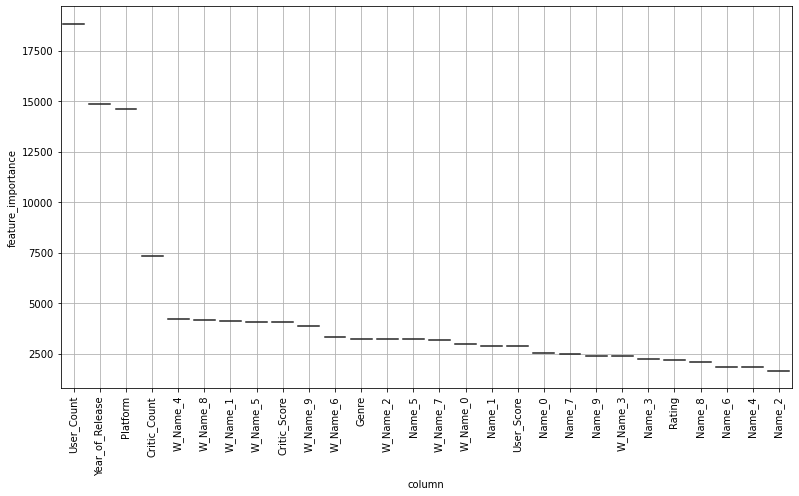

In [27]:
fig, ax = visualize_importance(model, X)


In [25]:
importance = pd.DataFrame(model.feature_importance(importance_type='gain'), index=train_df_drop.columns, columns=['importance'])
importance.sort_values(['importance'])

,importance
Rating,1923.628176
Developer_0,2262.207175
Developer_1,2521.593219
User_Score,3441.732117
Genre,4986.717704
Critic_Score,5141.556932
Critic_Count,7634.363927
Name_0,8909.336788
Name_1,10338.221252
Publisher_1,12838.359179


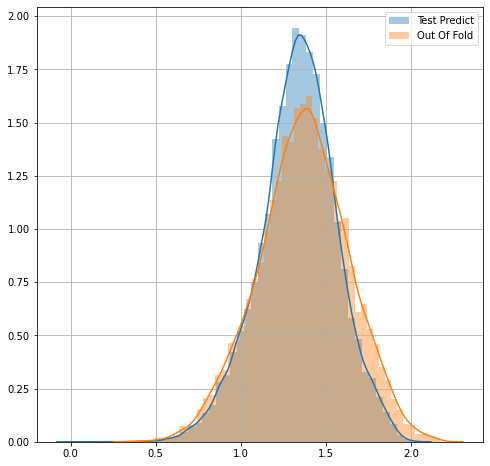

In [26]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.distplot(np.log1p(pred_test_np), label='Test Predict')
sns.distplot(np.log1p(oof_pred), label='Out Of Fold')
ax.legend()
ax.grid()

In [27]:
train_df_drop.corr().style.background_gradient(axis=None)